In [ ]:
# default_exp utils

# Utilities

> Helper functions used throughout the library not related to timeseries data.

In [ ]:
#export
from tsai.imports import *
from fastcore.test import *
import inspect
import sklearn

In [ ]:
# ensure these folders exist for testing purposes
fns = ['data', 'export', 'models']
for fn in fns: 
    path = Path('.')/fn
    if not os.path.exists(path): os.makedirs(path)

In [ ]:
#export
def totensor(o):
    if isinstance(o, torch.Tensor): return o
    elif isinstance(o, np.ndarray):  return torch.from_numpy(o)
    else: 
        try: return torch.tensor(o)
        except: warnings.warn(f"Can't convert {type(o)} to torch.Tensor", Warning)


def toarray(o):
    if isinstance(o, np.ndarray): return o
    elif isinstance(o, torch.Tensor): return o.cpu().numpy()
    else:
        try: return np.asarray(o)
        except: warnings.warn(f"Can't convert {type(o)} to np.array", Warning)
    
    
def toL(o):
    if isinstance(o, L): return o
    elif isinstance(o, (np.ndarray, torch.Tensor)): return L(o.tolist())
    else:
        try: return L(o)
        except: warnings.warn(f'passed object needs to be of type L, list, np.ndarray or torch.Tensor but is {type(o)}', Warning)


def to3dtensor(o):
    o = totensor(o)
    if o.ndim == 3: return o
    elif o.ndim == 1: return o[None, None]
    elif o.ndim == 2: return o[:, None]
    assert False, f'Please, review input dimensions {o.ndim}'


def to2dtensor(o):
    o = totensor(o)
    if o.ndim == 2: return o
    elif o.ndim == 1: return o[None]
    elif o.ndim == 3: return o[0]
    assert False, f'Please, review input dimensions {o.ndim}'


def to1dtensor(o):
    o = totensor(o)
    if o.ndim == 1: return o
    elif o.ndim == 3: return o[0,0]
    if o.ndim == 2: return o[0]
    assert False, f'Please, review input dimensions {o.ndim}'


def to3darray(o):
    o = toarray(o)
    if o.ndim == 3: return o
    elif o.ndim == 1: return o[None, None]
    elif o.ndim == 2: return o[:, None]
    assert False, f'Please, review input dimensions {o.ndim}'


def to2darray(o):
    o = toarray(o)
    if o.ndim == 2: return o
    elif o.ndim == 1: return o[None]
    elif o.ndim == 3: return o[0]
    assert False, f'Please, review input dimensions {o.ndim}'


def to1darray(o):
    o = toarray(o)
    if o.ndim == 1: return o
    elif o.ndim == 3: o = o[0,0]
    elif o.ndim == 2: o = o[0]
    assert False, f'Please, review input dimensions {o.ndim}'
    
    
def to3d(o):
    if o.ndim == 3: return o
    if isinstance(o, np.ndarray): return to3darray(o)
    if isinstance(o, torch.Tensor): return to3dtensor(o)
    
    
def to2d(o):
    if o.ndim == 2: return o
    if isinstance(o, np.ndarray): return to2darray(o)
    if isinstance(o, torch.Tensor): return to2dtensor(o)
    
    
def to1d(o):
    if o.ndim == 1: return o
    if isinstance(o, np.ndarray): return to1darray(o)
    if isinstance(o, torch.Tensor): return to1dtensor(o)
    
    
def to2dPlus(o):
    if o.ndim >= 2: return o
    if isinstance(o, np.ndarray): return to2darray(o)
    elif isinstance(o, torch.Tensor): return to2dtensor(o)
    
    
def to3dPlus(o):
    if o.ndim >= 3: return o
    if isinstance(o, np.ndarray): return to3darray(o)
    elif isinstance(o, torch.Tensor): return to3dtensor(o)
    
    
def to2dPlusTensor(o):
    return to2dPlus(totensor(o))


def to2dPlusArray(o):
    return to2dPlus(toarray(o))


def to3dPlusTensor(o):
    return to3dPlus(totensor(o))


def to3dPlusArray(o):
    return to3dPlus(toarray(o))


def todtype(dtype):
    def _to_type(o, dtype=dtype):
        if o.dtype == dtype: return o
        elif isinstance(o, torch.Tensor): o = o.to(dtype=dtype)
        elif isinstance(o, np.ndarray): o = o.astype(dtype)
        return o
    return _to_type

In [ ]:
a = np.random.rand(100).astype(np.float32)
b = torch.from_numpy(a).float()
test_eq(totensor(a), b)
test_eq(a, toarray(b))
test_eq(to3dtensor(a).ndim, 3)
test_eq(to2dtensor(a).ndim, 2)
test_eq(to1dtensor(a).ndim, 1)
test_eq(to3darray(b).ndim, 3)
test_eq(to2darray(b).ndim, 2)
test_eq(to1darray(b).ndim, 1)

In [ ]:
#export
def bytes2size(size_bytes):
    if size_bytes == 0: return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

def bytes2GB(byts):
    return round(byts / math.pow(1024, 3), 2)

def get_size(o, return_str=False):
    s = sys.getsizeof(o)
    if return_str: return bytes2size(s)
    else: return s

In [ ]:
a = np.random.rand(10, 5, 3)
test_eq(get_size(a, True), '1.3 KB')

In [ ]:
#export
def is_file(file_path):
    return os.path.isfile(file_path)

In [ ]:
test_eq(is_file("000_utils.ipynb"), True)
test_eq(is_file("utils.ipynb"), False)

In [ ]:
#export
def delete_all_in_dir(tgt_dir, exception=None):
    if exception is not None and len(L(exception)) > 1: exception = tuple(exception)
    for file in os.listdir(tgt_dir):
        if exception is not None and file.endswith(exception): continue
        file_path = os.path.join(tgt_dir, file)
        if os.path.isfile(file_path) or os.path.islink(file_path): os.unlink(file_path)
        elif os.path.isdir(file_path): shutil.rmtree(file_path)

In [ ]:
#export
def reverse_dict(dictionary): 
    return {v: k for k, v in dictionary.items()}

In [ ]:
#export
def is_tuple(o): return isinstance(o, tuple)

In [ ]:
#export
def itemify(*o, tup_id=None): 
    o = [o_ for o_ in L(*o) if o_ is not None]
    items = L(o).zip()
    if tup_id is not None: return L([item[tup_id] for item in items])
    else: return items

In [ ]:
a = [1, 2, 3]
b = [4, 5, 6]
print(itemify(a, b))
test_eq(len(itemify(a, b)), len(a))
a = [1, 2, 3]
b = None
print(itemify(a, b))
test_eq(len(itemify(a, b)), len(a))
a = [1, 2, 3]
b = [4, 5, 6]
c = None
print(itemify(a, b, c))
test_eq(len(itemify(a, b, c)), len(a))

[(1, 4), (2, 5), (3, 6)]
[(1,), (2,), (3,)]
[(1, 4), (2, 5), (3, 6)]


In [ ]:
#export
def isnone(o):
    return o is None

def exists(o): return o is not None

def ifelse(a, b, c):
    "`b` if `a` is True else `c`"
    return b if a else c

In [ ]:
a = np.array(3)
test_eq(isnone(a), False)
test_eq(exists(a), True)
b = None
test_eq(isnone(b), True)
test_eq(exists(b), False)

In [ ]:
#export
def is_not_close(a, b, eps=1e-5):
    "Is `a` within `eps` of `b`"
    if hasattr(a, '__array__') or hasattr(b, '__array__'):
        return (abs(a - b) > eps).all()
    if isinstance(a, (Iterable, Generator)) or isinstance(b, (Iterable, Generator)):
        return is_not_close(np.array(a), np.array(b), eps=eps)
    return abs(a - b) > eps


def test_not_close(a, b, eps=1e-5):
    "`test` that `a` is within `eps` of `b`"
    test(a, b, partial(is_not_close, eps=eps), 'not_close')


def test_type(a, b):
    return test_eq(type(a), type(b))


def test_ok(f, *args, **kwargs):
    try: 
        f(*args, **kwargs)
        e = 0
    except: 
        e = 1
        pass
    test_eq(e, 0)
    
def test_not_ok(f, *args, **kwargs):
    try: 
        f(*args, **kwargs)
        e = 0
    except: 
        e = 1
        pass
    test_eq(e, 1)
    
def test_error(error, f, *args, **kwargs):
    try: f(*args, **kwargs)
    except Exception as e: 
        test_eq(str(e), error)
        
        
def test_eq_nan(a,b):
    "`test` that `a==b` excluding nan values (valid for torch.Tensor and np.ndarray)"
    mask_a = torch.isnan(a) if isinstance(a, torch.Tensor) else np.isnan(a)
    mask_b = torch.isnan(b) if isinstance(b, torch.Tensor) else np.isnan(b)
    test(a[~mask_a],b[~mask_b],equals, '==')

In [ ]:
#export
def assert_fn(*args, **kwargs): assert False, 'assertion test'
test_error('assertion test', assert_fn, 35, a=3)

In [ ]:
#export
def test_gt(a,b):
    "`test` that `a>b`"
    test(a,b,gt,'>')

def test_ge(a,b):
    "`test` that `a>=b`"
    test(a,b,ge,'>')
    
def test_lt(a,b):
    "`test` that `a>b`"
    test(a,b,lt,'<')

def test_le(a,b):
    "`test` that `a>b`"
    test(a,b,le,'<=')

In [ ]:
test_ok(test_gt, 5, 4)
test_not_ok(test_gt, 4, 4)
test_ok(test_ge, 4, 4)
test_not_ok(test_ge, 3, 4)

test_ok(test_lt, 3, 4)
test_not_ok(test_lt, 4, 4)
test_ok(test_le, 4, 4)
test_not_ok(test_le, 5, 4)

In [ ]:
t = torch.rand(100)
t[t<.5] = np.nan
test_ne(t, t)
test_eq_nan(t, t)

In [ ]:
#export
def stack(o, axis=0, retain=True):
    if hasattr(o, '__array__'): return o
    if isinstance(o[0], torch.Tensor):
        return retain_type(torch.stack(tuple(o), dim=axis),  o[0]) if retain else torch.stack(tuple(o), dim=axis)
    else:
        return retain_type(np.stack(o, axis), o[0]) if retain else np.stack(o, axis)
    
    
def stack_pad(o, padding_value=np.nan):
    'Converts a an iterable into a numpy array using padding if necessary'
    row_length = len(max(o, key=len))
    result = np.full((len(o), row_length), padding_value)
    for i,row in enumerate(o): result[i, :len(row)] = row
    return result

In [ ]:
a = [[0,1,2], [4,5,6,7]]
test_eq(stack_pad(a).shape, (2, 4))
test_eq(type(stack_pad(a)), np.ndarray)
test_eq(np.isnan(stack_pad(a)).sum(), 1)

In [ ]:
a = np.random.rand(2, 3, 4)
t = torch.from_numpy(a)
test_eq_type(stack(itemify(a, tup_id=0)), a)
test_eq_type(stack(itemify(t, tup_id=0)), t)

In [ ]:
#export
def match_seq_len(*arrays):
    max_len = stack([x.shape[-1] for x in arrays]).max()
    return [np.pad(x, pad_width=((0,0), (0,0), (max_len - x.shape[-1], 0)), mode='constant', constant_values=0) for x in arrays]

In [ ]:
a = np.random.rand(10, 5, 8)
b = np.random.rand(3, 5, 10)
c, d = match_seq_len(a, b)
test_eq(c.shape[-1], d.shape[-1])

In [ ]:
#export
def random_shuffle(o, random_state=None):
    res = sklearn.utils.shuffle(o, random_state=random_state)
    if isinstance(o, L): return L(list(res))
    return res

In [ ]:
a = np.arange(10)
test_eq_type(random_shuffle(a, 1), np.array([2, 9, 6, 4, 0, 3, 1, 7, 8, 5]))
t = torch.arange(10)
test_eq_type(random_shuffle(t, 1), tensor([2, 9, 6, 4, 0, 3, 1, 7, 8, 5]))
l = list(a)
test_eq(random_shuffle(l, 1), [2, 9, 6, 4, 0, 3, 1, 7, 8, 5])
l2 = L(l)
test_eq_type(random_shuffle(l2, 1), L([2, 9, 6, 4, 0, 3, 1, 7, 8, 5]))

In [ ]:
#export
def cat2int(o):
    cat = Categorize()
    cat.setup(o)
    return stack(TfmdLists(o, cat)[:])

In [ ]:
a = np.array(['b', 'a', 'a', 'b', 'a', 'b', 'a'])
test_eq_type(cat2int(a), TensorCategory([1, 0, 0, 1, 0, 1, 0]))

In [ ]:
TensorBase([1,2,3])

TensorBase([1, 2, 3])

In [ ]:
#export
def cycle_dl(dl): 
    for _ in dl: _
        
def cycle_dl_to_device(dl):
    for bs in dl: [b.to(default_device()) for b in bs]
        
def cycle_dl_estimate(dl, iters=10):
    iters = min(iters, len(dl))
    iterator = iter(dl)
    timer.start(False)
    for _ in range(iters): next(iterator)
    t = timer.stop()
    return (t/iters * len(dl)).total_seconds()

In [ ]:
#export
def cache_data(o, slice_len=10_000, verbose=False):
    start = 0
    n_loops = (len(o) - 1) // slice_len + 1
    pv(f'{n_loops} loops', verbose)
    timer.start(False)
    for i in range(n_loops):
        o[slice(start,start + slice_len)]        
        if verbose and (i+1) % 10 == 0: print(f'{i+1:4} elapsed time: {timer.elapsed()}')
        start += slice_len
    pv(f'{i+1:4} total time  : {timer.stop()}\n', verbose)
    
memmap2cache =  cache_data
cache_memmap = cache_data

In [ ]:
#export
def get_func_defaults(f): 
    fa = inspect.getfullargspec(f)
    if fa.defaults is None: return dict(zip(fa.args, [''] * (len(fa.args))))
    else: return dict(zip(fa.args, [''] * (len(fa.args) - len(fa.defaults)) + list(fa.defaults)))

In [ ]:
#export
def get_idx_from_df_col_vals(df, col, val_list):
    return [df[df[col] == val].index[0] for val in val_list]

In [ ]:
#export
def get_sublist_idxs(aList, bList):
    "Get idxs that when applied to aList will return bList. aList must contain all values in bList"
    sorted_aList = aList[np.argsort(aList)]
    return np.argsort(aList)[np.searchsorted(sorted_aList, bList)]

In [ ]:
x = np.array([3, 5, 7, 1, 9, 8, 6, 2])
y = np.array([6, 1, 5, 7])
idx = get_sublist_idxs(x, y)
test_eq(x[idx], y)
x = np.array([3, 5, 7, 1, 9, 8, 6, 6, 2])
y = np.array([6, 1, 5, 7, 5])
idx = get_sublist_idxs(x, y)
test_eq(x[idx], y)

In [ ]:
#export
def flatten_list(l):
    return [item for sublist in l for item in sublist]

In [ ]:
#export
def display_pd_df(df, max_rows:Union[bool, int]=False, max_columns:Union[bool, int]=False):
    if max_rows:
        old_max_rows = pd.get_option('display.max_rows')
        if max_rows is not True and isinstance(max_rows, Integral): pd.set_option('display.max_rows', max_rows)
        else: pd.set_option('display.max_rows', df.shape[0])
    if max_columns:
        old_max_columns = pd.get_option('display.max_columns')
        if max_columns is not True and isinstance(max_columns, Integral): pd.set_option('display.max_columns', max_columns)
        else: pd.set_option('display.max_columns', df.shape[1])
    display(df)
    if max_rows: pd.set_option('display.max_rows', old_max_rows)
    if max_columns: pd.set_option('display.max_columns', old_max_columns)

In [ ]:
old_max_rows, old_max_columns = pd.get_option('display.max_rows'), pd.get_option('display.max_columns')
df = pd.DataFrame(np.random.rand(70, 25))
display_pd_df(df, max_rows=2, max_columns=3)
test_eq(old_max_rows, pd.get_option('display.max_rows'))
test_eq(old_max_columns, pd.get_option('display.max_columns'))

,0,...,24
0,0.964674,...,0.867469
...,...,...,...
69,0.006174,...,0.305245


In [ ]:
#export
def ttest(data1, data2, equal_var=False):
    "Calculates t-statistic and p-value based on 2 sample distributions"
    t_stat, p_value = scipy.stats.ttest_ind(data1, data2, equal_var=equal_var)
    return t_stat, np.sign(t_stat) * p_value

def tscore(o): 
    if o.std() == 0: return 0
    else: return np.sqrt(len(o)) * o.mean() / o.std()

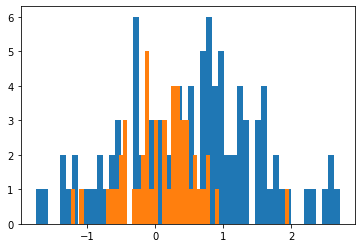

(3.34915738007649, 0.0010309397301177582)

In [ ]:
a = np.random.normal(0.5, 1, 100)
b = np.random.normal(0.15, .5, 50)
plt.hist(a, 50)
plt.hist(b, 50)
plt.show()
ttest(a,b)

In [ ]:
a = np.random.normal(0.5, 1, 100)
t = torch.normal(0.5, 1, (100, ))
tscore(a), tscore(t)

(5.631217023405957, tensor(6.7689))

In [ ]:
#export
def ttest_tensor(a, b):
    "differentiable pytorch function equivalent to scipy.stats.ttest_ind with equal_var=False"
    # calculate standard errors
    se1, se2 = torch.std(a)/np.sqrt(len(a)), torch.std(b)/np.sqrt(len(b))
    # standard error on the difference between the samples
    sed = torch.sqrt(se1**2.0 + se2**2.0)
    # calculate the t statistic
    t_stat = (torch.mean(a) - torch.mean(b)) / sed
    return t_stat

In [ ]:
a = torch.rand(100).requires_grad_(True) + .1
b = torch.rand(100).requires_grad_(True)
ttest_tensor(a, b)

tensor(3.1998, grad_fn=<DivBackward0>)

In [ ]:
#export
from scipy.stats import pearsonr, spearmanr

def pcc(a, b):
    return pearsonr(a, b)[0]

def scc(a, b):
    return spearmanr(a, b)[0]

a = np.random.normal(0.5, 1, 100)
b = np.random.normal(0.15, .5, 100)
pcc(a, b), scc(a, b)

(0.19024357664432584, 0.18763876387638762)

In [ ]:
#export
def remove_fn(fn, verbose=False):
    "Removes a file (fn) if exists"
    try: 
        os.remove(fn)
        pv(f'{fn} file removed', verbose)
    except OSError: 
        pv(f'{fn} does not exist', verbose)
        pass

In [ ]:
#export
def npsave(array_fn, array, verbose=True):
    remove_fn(array_fn, verbose)
    pv(f'saving {array_fn}...', verbose)
    np.save(array_fn, array)
    pv(f'...{array_fn} saved', verbose)
    
np_save = npsave

In [ ]:
fn = 'data/remove_fn_test.npy'
a = np.zeros(1)
npsave(fn, a)
del a
np.load(fn, mmap_mode='r+')
remove_fn(fn, True)
remove_fn(fn, True)

data/remove_fn_test.npy does not exist
saving data/remove_fn_test.npy...
...data/remove_fn_test.npy saved
data/remove_fn_test.npy file removed
data/remove_fn_test.npy does not exist


In [ ]:
#export
def permute_2D(array, axis=None):
    "Permute rows or columns in an array. This can be used, for example, in feature permutation"
    if axis == 0: return array[np.random.randn(*array.shape).argsort(axis=0), np.arange(array.shape[-1])[None, :]] 
    elif axis == 1 or axis == -1: return array[np.arange(len(array))[:,None], np.random.randn(*array.shape).argsort(axis=1)] 
    return array[np.random.randn(*array.shape).argsort(axis=0), np.random.randn(*array.shape).argsort(axis=1)] 

In [ ]:
s = np.arange(100 * 50).reshape(100, 50) 
test_eq(permute_2D(s, axis=0).mean(0), s.mean(0))
test_ne(permute_2D(s, axis=0), s)
test_eq(permute_2D(s, axis=1).mean(1), s.mean(1))
test_ne(permute_2D(s, axis=1), s)
test_ne(permute_2D(s), s)

In [ ]:
#export
def random_normal():
    "Returns a number between -1 and 1 with a normal distribution"
    while True:
        o = np.random.normal(loc=0., scale=1/3)
        if abs(o) <= 1: break
    return o

def random_half_normal():
    "Returns a number between 0 and 1 with a half-normal distribution"
    while True:
        o = abs(np.random.normal(loc=0., scale=1/3))
        if o <= 1: break
    return o

def random_normal_tensor(shape=1, device=None):
    "Returns a tensor of a predefined shape between -1 and 1 with a normal distribution"
    return torch.empty(shape, device=device).normal_(mean=0, std=1/3).clamp_(-1, 1)

def random_half_normal_tensor(shape=1, device=None):
    "Returns a tensor of a predefined shape between 0 and 1 with a half-normal distribution"
    return abs(torch.empty(shape, device=device).normal_(mean=0, std=1/3)).clamp_(0, 1)

In [ ]:
#export
from matplotlib.backends.backend_agg import FigureCanvasAgg

def default_dpi():
    DPI = plt.gcf().get_dpi()
    plt.close()
    return int(DPI)

def get_plot_fig(size=None, dpi=default_dpi()):
    fig = plt.figure(figsize=(size / dpi, size / dpi), dpi=dpi, frameon=False) if size else plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    config = plt.gcf()
    plt.close('all')
    return config

def fig2buf(fig):
    canvas = FigureCanvasAgg(fig)
    fig.canvas.draw()
    return np.asarray(canvas.buffer_rgba())[..., :3]

In [ ]:
default_dpi()

72

In [ ]:
#export
def plot_scatter(x, y, deg=1):
    linreg = sp.stats.linregress(x, y)
    plt.scatter(x, y, label=f'R2:{linreg.rvalue:.2f}', color='lime', edgecolor='black', alpha=.5)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, deg))(np.unique(x)), color='r')
    plt.legend(loc='best')
    plt.show()

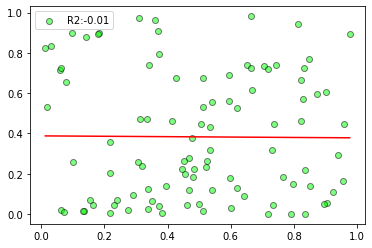

In [ ]:
a = np.random.rand(100)
b = np.random.rand(100)**2
plot_scatter(a, b)

In [ ]:
#export
def get_idxs(o, aList): return array([o.tolist().index(v) for v in aList])

In [ ]:
a = random_shuffle(np.arange(100, 200))
b = np.random.choice(a, 10, False)
idxs = get_idxs(a, b)
test_eq(a[idxs], b)

In [ ]:
#export
def apply_cmap(o, cmap):
    o = toarray(o)
    out = plt.get_cmap(cmap)(o)[..., :3]
    out = tensor(out).squeeze(1)
    return out.permute(0, 3, 1, 2)

In [ ]:
a = np.random.rand(16, 1, 40, 50)
s = L(a.shape)
s[1] = 3
test_eq(L(apply_cmap(a, 'viridis').shape), s)

s[0] = 1
a = np.random.rand(1, 40, 50)
test_eq(L(apply_cmap(a, 'viridis').shape), s)

In [ ]:
#export
def torch_tile(a, n_tile, dim=0):
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = torch.cat([init_dim * torch.arange(n_tile) + i for i in range(init_dim)]).to(device=a.device)
    return torch.index_select(a, dim, order_index)

In [ ]:
test_eq(torch_tile(torch.arange(2), 3), tensor([0, 0, 0, 1, 1, 1]))

In [ ]:
#export
def to_tsfresh_df(ts):
    r"""Prepares a time series (Tensor/ np.ndarray) to be used as a tsfresh dataset to allow feature extraction"""
    ts = to3d(ts)
    if isinstance(ts, np.ndarray):
        ids = np.repeat(np.arange(len(ts)), ts.shape[-1]).reshape(-1,1)
        joint_ts =  ts.transpose(0,2,1).reshape(-1, ts.shape[1])
        cols = ['id'] + np.arange(ts.shape[1]).tolist()
        df = pd.DataFrame(np.concatenate([ids, joint_ts], axis=1), columns=cols)
    elif isinstance(ts, torch.Tensor):
        ids = torch_tile(torch.arange(len(ts)), ts.shape[-1]).reshape(-1,1)
        joint_ts =  ts.transpose(1,2).reshape(-1, ts.shape[1])
        cols = ['id']+np.arange(ts.shape[1]).tolist()
        df = pd.DataFrame(torch.cat([ids, joint_ts], dim=1).numpy(), columns=cols)
    df['id'] = df['id'].astype(int)
    df.reset_index(drop=True, inplace=True)
    return df

In [ ]:
ts = torch.rand(16, 3, 20)
a = to_tsfresh_df(ts)
ts = ts.numpy()
b = to_tsfresh_df(ts)

In [ ]:
#export
from scipy.stats import skew, kurtosis

def pcorr(a, b): 
    return scipy.stats.pearsonr(a, b)

def scorr(a, b): 
    corr = scipy.stats.spearmanr(a, b)
    return corr[0], corr[1]

In [ ]:
#export
def torch_diff(t, lag=1, pad=True):
    import torch.nn.functional as F
    diff = t[..., lag:] - t[..., :-lag]
    if pad: return F.pad(diff, (lag,0))
    else: return diff

In [ ]:
t = torch.arange(24).reshape(2,3,4)
test_eq(torch_diff(t, 1)[..., 1:].float().mean(), 1.)
test_eq(torch_diff(t, 2)[..., 2:].float().mean(), 2.)

In [ ]:
#export
def get_outliers_IQR(o, axis=None):
    tt = False
    if isinstance(o, torch.Tensor): 
        tt = True
        device = o.device
        tdtype = o.dtype
        o = o.detach().cpu().numpy()
    Q1 = np.nanpercentile(o, 25, axis=axis, keepdims=axis is not None)
    Q3 = np.nanpercentile(o, 75, axis=axis, keepdims=axis is not None)
    IQR = Q3 - Q1
    if tt: 
        Q1 = torch.tensor(Q1, dtype=tdtype, device=device)
        Q3 = torch.tensor(Q3, dtype=tdtype, device=device)
        IQR = torch.tensor(IQR, dtype=tdtype, device=device)
    return Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

def clip_outliers(o, axis=None):
    min_outliers, max_outliers = get_outliers_IQR(o, axis=axis)
    if isinstance(o, (np.ndarray, pd.core.series.Series)):
        return np.clip(o, min_outliers, max_outliers)
    elif isinstance(o, torch.Tensor):
        return torch.clamp(o, min_outliers, max_outliers)

def get_percentile(o, percentile, axis=None):
    if isinstance(o, torch.Tensor): o = o.detach().cpu().numpy()
    return np.nanpercentile(o, percentile, axis=axis, keepdims=axis is not None)

def torch_clamp(o, min=None, max=None):
    r"""Clamp torch.Tensor using 1 or multiple dimensions"""
    if min is not None: o = torch.max(o, min)
    if max is not None: o = torch.min(o, max)
    return o

In [ ]:
t = torch.randn(2,3,100)
test_eq(type(get_outliers_IQR(t, -1)[0]), torch.Tensor)
a = np.random.randn(2,3,100)
test_eq(type(get_outliers_IQR(a, -1)[0]), np.ndarray)

In [ ]:
#export
def torch_slice_by_dim(t, index, dim=-1, **kwargs):
    if not isinstance(index, torch.Tensor): index = torch.Tensor(index)
    assert t.ndim == index.ndim, "t and index must have the same ndim"
    index = index.long()
    return torch.gather(t, dim, index, **kwargs)

In [ ]:
t = torch.rand(5, 3)
index = torch.randint(0, 3, (5, 1))
# index = [[0, 2], [0, 1], [1, 2], [0, 2], [0, 1]]
torch_slice_by_dim(t, index)

tensor([[0.6046],
        [0.4139],
        [0.7298],
        [0.5382],
        [0.4741]])

In [ ]:
#export
def torch_nanmean(o, dim=None, keepdim=False):
    """There's currently no torch.nanmean function"""
    mask = torch.isnan(o)
    if mask.any():
        output = torch.from_numpy(np.asarray(np.nanmean(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)
        if output.shape == mask.shape:
            output[mask] = 0
        return output
    else:
        return torch.mean(o, dim=dim, keepdim=keepdim) if dim is not None else torch.mean(o)


def torch_nanstd(o, dim=None, keepdim=False):
    """There's currently no torch.nanstd function"""
    mask = torch.isnan(o)
    if mask.any():
        output = torch.from_numpy(np.asarray(np.nanstd(o.cpu().numpy(), axis=dim, keepdims=keepdim))).to(o.device)
        if output.shape == mask.shape:
            output[mask] = 1
        return output
    else:
        return torch.std(o, dim=dim, keepdim=keepdim) if dim is not None else torch.std(o)

In [ ]:
t = torch.rand(1000)
t[:100] = float('nan')
assert torch_nanmean(t).item() > 0

In [ ]:
#export
def concat(*ls, dim=0):
    "Concatenate tensors, arrays, lists, or tuples by a dimension"
    if not len(ls): return []
    it = ls[0]
    if isinstance(it, torch.Tensor): return torch.cat(ls, dim=dim)
    elif isinstance(it, np.ndarray): return np.concatenate(ls, axis=dim)
    else:
        res = np.concatenate(ls, axis=dim).tolist()
        return retain_type(res, typ=type(it))

In [ ]:
#export
def reduce_memory_usage(df):
    
    start_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_memory} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    end_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe after reduction {end_memory} MB")
    print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
    return df

In [ ]:
#export
def cls_name(o): return o.__class__.__name__

In [ ]:
test_eq(cls_name(timer), 'Timer')

In [ ]:
#export
def roll2d(o, roll1: Union[None, list, int] = None, roll2: Union[None, list, int] = None):
    """Rolls a 2D object on the indicated axis
    This solution is based on https://stackoverflow.com/questions/20360675/roll-rows-of-a-matrix-independently
    """
    
    assert o.ndim == 2, "roll2D can only be applied to 2d objects"
    axis1, axis2 = np.ogrid[:o.shape[0], :o.shape[1]]
    if roll1 is not None:
        if isinstance(roll1, int): axis1 = axis1 - np.array(roll1).reshape(1,1)
        else: axis1 = np.array(roll1).reshape(o.shape[0],1)
    if roll2:
        if isinstance(roll2, int):  axis2 = axis2 - np.array(roll2).reshape(1,1)
        else: axis2 = np.array(roll2).reshape(1,o.shape[1])
    return o[axis1, axis2]


def roll3d(o, roll1: Union[None, list, int] = None, roll2: Union[None, list, int] = None, roll3: Union[None, list, int] = None):
    """Rolls a 3D object on the indicated axis
    This solution is based on https://stackoverflow.com/questions/20360675/roll-rows-of-a-matrix-independently
    """
    
    assert o.ndim == 3, "roll3D can only be applied to 3d objects"
    axis1, axis2, axis3 = np.ogrid[:o.shape[0], :o.shape[1], :o.shape[2]]
    if roll1 is not None:
        if isinstance(roll1, int): axis1 = axis1 - np.array(roll1).reshape(1,1,1)
        else: axis1 = np.array(roll1).reshape(o.shape[0],1,1)
    if roll2:
        if isinstance(roll2, int):  axis2 = axis2 - np.array(roll2).reshape(1,1,1)
        else: axis2 = np.array(roll2).reshape(1,o.shape[1],1)
    if roll3:
        if isinstance(roll3, int):  axis3 = axis3 - np.array(roll3).reshape(1,1,1)
        else: axis3 = np.array(roll3).reshape(1,1,o.shape[2])
    return o[axis1, axis2, axis3]


def random_roll2d(o, axis=()):
    """Rolls a 2D object on the indicated axis
    This solution is based on https://stackoverflow.com/questions/20360675/roll-rows-of-a-matrix-independently
    """
    
    assert o.ndim == 2, "roll2D can only be applied to 2d objects"
    axis1, axis2 = np.ogrid[:o.shape[0], :o.shape[1]]
    if 0 in axis:
        axis1 = np.random.choice(np.arange(o.shape[0]), o.shape[0], replace).reshape(-1, 1)
    if 1 in axis:
        axis2 = np.random.choice(np.arange(o.shape[1]), o.shape[1], replace).reshape(1, -1)
    return o[axis1, axis2]


def random_roll3d(o, axis=(), replace=False):
    """Randomly rolls a 3D object along the indicated axes
    This solution is based on https://stackoverflow.com/questions/20360675/roll-rows-of-a-matrix-independently
    """
    
    assert o.ndim == 3, "random_roll3d can only be applied to 3d objects"
    axis1, axis2, axis3 = np.ogrid[:o.shape[0], :o.shape[1], :o.shape[2]]
    if 0 in axis:
        axis1 = np.random.choice(np.arange(o.shape[0]), o.shape[0], replace).reshape(-1, 1, 1)
    if 1 in axis:
        axis2 = np.random.choice(np.arange(o.shape[1]), o.shape[1], replace).reshape(1, -1, 1)
    if 2 in axis:
        axis3 = np.random.choice(np.arange(o.shape[2]), o.shape[2], replace).reshape(1, 1, -1)
    return o[axis1, axis2, axis3]

def rotate_axis0(o, steps=1):
    return o[np.arange(o.shape[0]) - steps]

def rotate_axis1(o, steps=1):
    return o[:, np.arange(o.shape[1]) - steps]

def rotate_axis2(o, steps=1):
    return o[:, :, np.arange(o.shape[2]) - steps]

In [ ]:
a = np.tile(np.arange(10), 3).reshape(3, 10) * np.array([1, 10, 100]).reshape(-1, 1)
a

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9],
       [  0,  10,  20,  30,  40,  50,  60,  70,  80,  90],
       [  0, 100, 200, 300, 400, 500, 600, 700, 800, 900]])

In [ ]:
roll2d(a, roll1=[2, 1, 0])

array([[  0, 100, 200, 300, 400, 500, 600, 700, 800, 900],
       [  0,  10,  20,  30,  40,  50,  60,  70,  80,  90],
       [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9]])

In [ ]:
roll2d(a, roll2=3)

array([[  7,   8,   9,   0,   1,   2,   3,   4,   5,   6],
       [ 70,  80,  90,   0,  10,  20,  30,  40,  50,  60],
       [700, 800, 900,   0, 100, 200, 300, 400, 500, 600]])

In [ ]:
o = torch.arange(24).reshape(2,3,4)
test_eq(rotate_axis0(o)[1], o[0])
test_eq(rotate_axis1(o)[:,1], o[:,0])
test_eq(rotate_axis2(o)[...,1], o[...,0])

In [ ]:
#export
def chunks_calculator(shape, dtype='float32', n_bytes=1024**3):
    """Function to calculate chunks for a given size of n_bytes (default = 1024**3 == 1GB). 
    It guarantees > 50% of the chunk will be filled"""
    
    X  = np.random.rand(1, *shape[1:]).astype(dtype)
    byts = get_size(X)
    n = n_bytes // byts
    if shape[0] / n <= 1: return False
    remainder = shape[0] % n
    if remainder / n < .5: 
        n_chunks = shape[0] // n
        n += np.ceil(remainder / n_chunks).astype(int)
    return (n, -1, -1)

In [ ]:
shape = (1_000, 10, 1000)
dtype = 'float32'
test_eq(chunks_calculator(shape, dtype), False)

shape = (54684, 10, 1000)
dtype = 'float32'
test_eq(chunks_calculator(shape, dtype), (27342, -1, -1))

In [ ]:
#export
def is_memory_shared(a, b):
    r"""Test function to check if 2 array-like object share memory. 
    Be careful because it changes their values!!!)"""
    
    try: 
        a[:] = 1
    except: 
        try: 
            b[:] = 1
        except: 
            print('unknown')
            return 
    return torch.equal(tensor(a), tensor(b))

In [ ]:
a = np.random.rand(2,3,4)
t1 = torch.from_numpy(a)
test_eq(is_memory_shared(a, t1), True)
a = np.random.rand(2,3,4)
t2 = torch.as_tensor(a)
test_eq(is_memory_shared(a, t2), True)
a = np.random.rand(2,3,4)
t3 = torch.tensor(a)
test_eq(is_memory_shared(a, t3), False)

In [ ]:
#export
def assign_in_chunks(a, b, chunksize='auto', inplace=True, verbose=True):
    """Assigns values in b to an array-like object a using chunks to avoid memory overload.
    
    The resulting a retains it's dtype and share it's memory.
    a: array-like object
    b: may be an integer, float, str, 'rand' (for random data), or another array like object.
    chunksize: is the size of chunks. If 'auto' chunks will have around 1GB each. 
    """
    
    if b != 'rand' and not isinstance(b, (Iterable, Generator)):
        a[:] = b
    else:
        shape = a.shape
        dtype = a.dtype
        if chunksize == "auto": 
            chunksize = chunks_calculator(shape, dtype)
            chunksize = shape[0] if not chunksize else  chunksize[0]
        for i in progress_bar(range((shape[0] - 1) // chunksize + 1), display=verbose, leave=False):
            start, end = i * chunksize, min(shape[0], (i + 1) * chunksize)
            if start >= shape[0]: break
            if b == 'rand': 
                a[start:end] = np.random.rand(end - start, *shape[1:])
            else: 
                a[start:end] = b[start:end]
    if not inplace: return a

In [ ]:
a = np.random.rand(10,3,4).astype('float32')
a_dtype = a.dtype
a_id = id(a)
b = np.random.rand(10,3,4).astype('float64')
assign_in_chunks(a, b, chunksize=2, inplace=True, verbose=True)
test_close(a, b)
test_eq(a.dtype, a_dtype)
test_eq(id(a), a_id)

a = np.random.rand(10,3,4).astype('float32')
a_dtype = a.dtype
a_id = id(a)
b = 1
assign_in_chunks(a, b, chunksize=2, inplace=True, verbose=True)
test_eq(a, np.ones_like(a).astype(a.dtype))
test_eq(a.dtype, a_dtype)
test_eq(id(a), a_id)

a = np.random.rand(10,3,4).astype('float32')
a_dtype = a.dtype
a_id = id(a)
b = 0.5
assign_in_chunks(a, b, chunksize=2, inplace=True, verbose=True)
test_eq(a.dtype, a_dtype)
test_eq(id(a), a_id)

a = np.random.rand(10,3,4).astype('float32')
a_dtype = a.dtype
a_id = id(a)
b = 'rand'
assign_in_chunks(a, b, chunksize=2, inplace=True, verbose=True)
test_eq(a.dtype, a_dtype)
test_eq(id(a), a_id)

In [ ]:
a = np.random.rand(10,3,4).astype('float32')
b = np.random.rand(10,3,4).astype('float64')
c = assign_in_chunks(a, b, chunksize=2, inplace=False, verbose=True)
test_close(c, b)
test_eq(a.dtype, c.dtype)
test_eq(is_memory_shared(a, c), True)

a = np.random.rand(10,3,4).astype('float32')
b = 1
c = assign_in_chunks(a, b, chunksize=2, inplace=False, verbose=True)
test_eq(a, np.ones_like(a).astype(a.dtype))
test_eq(a.dtype, c.dtype)
test_eq(is_memory_shared(a, c), True)

a = np.random.rand(10,3,4).astype('float32')
b = 0.5
c = assign_in_chunks(a, b, chunksize=2, inplace=False, verbose=True)
test_eq(a.dtype, c.dtype)
test_eq(is_memory_shared(a, c), True)

a = np.random.rand(10,3,4).astype('float32')
b = 'rand'
c = assign_in_chunks(a, b, chunksize=2, inplace=False, verbose=True)
test_eq(a.dtype, c.dtype)
test_eq(is_memory_shared(a, c), True)

In [ ]:
#export
def create_array(shape, fname=None, path='./data', on_disk=True, dtype='float32', mode='r+', fill_value='rand', chunksize='auto', verbose=True, **kwargs):
    """
    mode:
        ‘r’:  Open existing file for reading only.
        ‘r+’: Open existing file for reading and writing.
        ‘w+’: Create or overwrite existing file for reading and writing.
        ‘c’:  Copy-on-write: assignments affect data in memory, but changes are not saved to disk. The file on disk is read-only.
    fill_value: 'rand' (for random numbers), int or float
    chunksize = 'auto' to calculate chunks of 1GB, or any integer (for a given number of samples)
    """
    if on_disk:
        assert fname is not None, 'you must provide a fname (filename)'
        path = Path(path)
        if not fname.endswith('npy'): fname = f'{fname}.npy'
        filename = path/fname
        filename.parent.mkdir(parents=True, exist_ok=True)
        # Save a small empty array
        _temp_fn = path/'temp_X.npy'
        np.save(_temp_fn, np.empty(0))
        # Create  & save file
        arr = np.memmap(_temp_fn, dtype=dtype, mode='w+', shape=shape, **kwargs)
        np.save(filename, arr)
        del arr
        os.remove(_temp_fn)
        # Open file in selected mode
        arr = np.load(filename, mmap_mode=mode)
    else:
        arr = np.empty(shape, dtype=dtype, **kwargs)
    if fill_value != 0:
        assign_in_chunks(arr, fill_value, chunksize=chunksize, inplace=True, verbose=verbose)
    return arr

create_empty_array = partial(create_array, fill_value=0)

In [ ]:
fname = 'X_on_disk'
shape = (100, 10, 10)
X = create_array(shape, fname, on_disk=True, mode='r+')
test_ne(abs(X).sum(), 0)
os.remove(X.filename)
del X

In [ ]:
fname = 'X_on_disk'
shape = (100, 10, 10)
X = create_empty_array(shape, fname, on_disk=True, mode='r+')
test_eq(abs(X).sum(), 0)

chunksize = 10
pbar = progress_bar(range(math.ceil(len(X) / chunksize)), leave=False)
start = 0
for i in pbar: 
    end = min(start + chunksize, len(X))
    partial_data = np.random.rand(end - start, X.shape[1] , X.shape[2])
    X[start:end] = partial_data
    start = end
    del partial_data
    gc.collect()
filename = X.filename
del X
X = np.load(filename, mmap_mode='r+')
test_eq((X == 0).sum(), 0)
test_eq(X.shape, shape)
os.remove(X.filename)
del X

In [ ]:
#export
import gzip

def np_save_compressed(arr, fname=None, path='./data', verbose=False, **kwargs):
    assert fname is not None, 'you must provide a fname (filename)'
    if fname.endswith('npy'): fname = f'{fname}.gz'
    elif not fname.endswith('npy.gz'): fname = f'{fname}.npy.gz'
    filename = Path(path)/fname
    filename.parent.mkdir(parents=True, exist_ok=True)
    f = gzip.GzipFile(filename, 'w', **kwargs)
    np.save(file=f, arr=arr)
    f.close()
    pv(f'array saved to {filename}', verbose)
    
def np_load_compressed(fname=None, path='./data', **kwargs):
    assert fname is not None, 'you must provide a fname (filename)'
    if fname.endswith('npy'): fname = f'{fname}.gz'
    elif not fname.endswith('npy.gz'): fname = f'{fname}.npy.gz'
    filename = Path(path)/fname
    f = gzip.GzipFile(filename, 'r', **kwargs)
    arr = np.load(f)
    f.close()
    return arr

In [ ]:
X1 = np.random.rand(10)
np_save_compressed(X1, 'X_comp', path='./data')
X2 = np_load_compressed('X_comp')
test_eq(X1, X2)

In [ ]:
#export
def np2memmap(arr, fname=None, path='./data', dtype='float32', mode='c', **kwargs):
    """ Function that turns an ndarray into a memmap ndarray
    mode:
        ‘r’:  Open existing file for reading only.
        ‘r+’: Open existing file for reading and writing.
        ‘w+’: Create or overwrite existing file for reading and writing.
        ‘c’:  Copy-on-write: assignments affect data in memory, but changes are not saved to disk. The file on disk is read-only.
    """
    assert fname is not None, 'you must provide a fname (filename)'
    if not fname.endswith('npy'): fname = f'{fname}.npy'
    filename = Path(path)/fname
    filename.parent.mkdir(parents=True, exist_ok=True)
    # Save file
    np.save(filename, arr)
    # Open file in selected mode
    arr = np.load(filename, mmap_mode=mode)
    return arr

In [ ]:
X1 = np.random.rand(10)
X2 = np2memmap(X1, 'X1_test')
test_eq(X1, X2)
test_ne(type(X1), type(X2))

In [ ]:
#export 
def torch_mean_groupby(o, idxs):
    """Computes torch mean along axis 0 grouped by the idxs. 
    Need to ensure that idxs have the same order as o"""
    if is_listy(idxs[0]): idxs = flatten_list(idxs)
    flattened_idxs = torch.tensor(idxs)
    idxs, vals = torch.unique(flattened_idxs, return_counts=True)
    vs = torch.split_with_sizes(o, tuple(vals))
    return torch.cat([v.mean(0).unsqueeze(0) for k,v in zip(idxs, vs)])

In [ ]:
o = torch.arange(6*2*3).reshape(6, 2, 3).float()
idxs = np.array([[0,1,2,3], [2,3]], dtype=object)
output = torch_mean_groupby(o, idxs)
test_eq(o[:2], output[:2])
test_eq(o[2:4].mean(0), output[2])
test_eq(o[4:6].mean(0), output[3])

In [ ]:
#export
def torch_flip(t, dims=-1):
    if dims == -1: return t[..., np.arange(t.shape[dims])[::-1].copy()]
    elif dims == 0: return t[np.arange(t.shape[dims])[::-1].copy()]
    elif dims == 1: return t[:, np.arange(t.shape[dims])[::-1].copy()]
    elif dims == 2: return t[:, :, np.arange(t.shape[dims])[::-1].copy()]

In [ ]:
t = torch.randn(2, 3, 4)
test_eq(torch.flip(t, (2,)), torch_flip(t, dims=-1))

In [ ]:
#export 
def torch_nan_to_num(o, num=0, inplace=False):
    mask = torch.isnan(o)
    return torch_masked_to_num(o, mask, num=num, inplace=inplace)

def torch_masked_to_num(o, mask, num=0, inplace=False):
    if inplace: 
        o[:] = o.masked_fill(mask, num)
    else: 
        return o.masked_fill(mask, num)

In [ ]:
x = torch.rand(2, 4, 6)
x[:, :3][x[:, :3] < .5] = np.nan
nan_values = torch.isnan(x).sum()
y = torch_nan_to_num(x[:, :3], inplace=False)
test_eq(torch.isnan(y).sum(), 0)
test_eq(torch.isnan(x).sum(), nan_values)
torch_nan_to_num(x[:, :3], inplace=True)
test_eq(torch.isnan(x).sum(), 0)

In [ ]:
x = torch.rand(2, 4, 6)
mask = x[:, :3] > .5
x[:, :3] = torch_masked_to_num(x[:, :3], mask, num=0, inplace=False)
test_eq(x[:, :3][mask].sum(), 0)

In [ ]:
x = torch.rand(2, 4, 6)
mask = x[:, :3] > .5
torch_masked_to_num(x[:, :3], mask, num=0, inplace=True)
test_eq(x[:, :3][mask].sum(), 0)

In [ ]:
#export
def mpl_trend(x, y, deg=1): 
    return np.poly1d(np.polyfit(x, y, deg))(x)

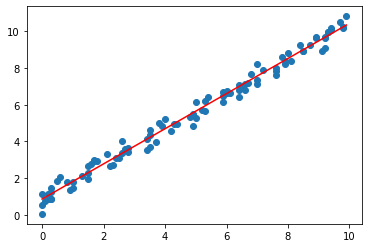

In [ ]:
x = np.sort(np.random.randint(0, 100, 100)/10)
y = np.random.rand(100) + np.linspace(0, 10, 100)
trend = mpl_trend(x, y)
plt.scatter(x, y)
plt.plot(x, trend, 'r')
plt.show()

In [ ]:
#export
def int2digits(o, n_digits=None, normalize=True):
    if n_digits is not None:
        iterable = '0' * (n_digits - len(str(abs(o)))) + str(abs(o))
    else:
        iterable = str(abs(o))
    sign = np.sign(o)
    digits = np.array([sign * int(d) for d in iterable])
    if normalize:
        digits = digits / 10
    return digits


def array2digits(o, n_digits=None, normalize=True):
    output = np.array(list(map(partial(int2digits, n_digits=n_digits), o)))
    if normalize:
        output = output / 10
    return output

In [ ]:
o = -9645
test_eq(int2digits(o, 6), np.array([ 0,  0, -.9, -.6, -.4, -.5]))

a = np.random.randint(-1000, 1000, 10)
test_eq(array2digits(a,5).shape, (10,5))

In [ ]:
#export
def sincos_encoding(seq_len, device=None, to_np=False):
    if to_np:
        sin = np.sin(np.arange(seq_len) / seq_len * 2 * np.pi)
        cos = np.cos(np.arange(seq_len) / seq_len * 2 * np.pi)
    else:
        device = default_device()
        sin = torch.sin(torch.arange(seq_len, device=device) / seq_len * 2 * np.pi)
        cos = torch.cos(torch.arange(seq_len, device=device) / seq_len * 2 * np.pi)
    return sin, cos

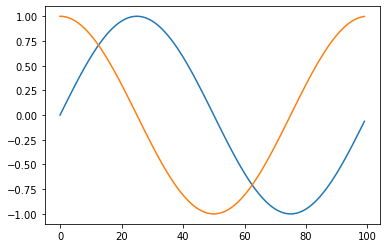

In [ ]:
sin, cos = sincos_encoding(100)
plt.plot(sin.cpu().numpy())
plt.plot(cos.cpu().numpy())
plt.show()

In [ ]:
#export
def linear_encoding(seq_len, device=None, to_np=False, lin_range=(-1,1)):
    if to_np:
        enc =  np.linspace(lin_range[0], lin_range[1], seq_len)
    else:
        device = default_device()
        enc = torch.linspace(lin_range[0], lin_range[1], seq_len, device=device)
    return enc

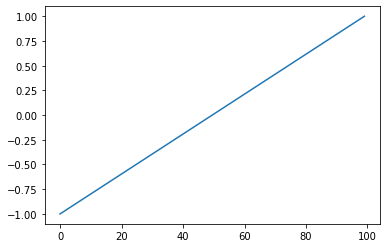

In [ ]:
lin = linear_encoding(100)
plt.plot(lin.cpu().numpy())
plt.show()

In [ ]:
#export
def encode_positions(pos_arr, min_val=None, max_val=None, linear=False, lin_range=(-1,1)):
    """ Encodes an array with positions using a linear or sincos methods
    """
    
    if min_val is None:
        min_val = np.nanmin(pos_arr)
    if max_val is None:
        max_val = np.nanmax(pos_arr)
        
    if linear: 
        return (((pos_arr - min_val)/(max_val - min_val)) * (lin_range[1] - lin_range[0]) + lin_range[0])
    else:
        sin = np.sin((pos_arr - min_val)/(max_val - min_val) * 2 * np.pi)
        cos = np.cos((pos_arr - min_val)/(max_val - min_val) * 2 * np.pi)
        return sin, cos

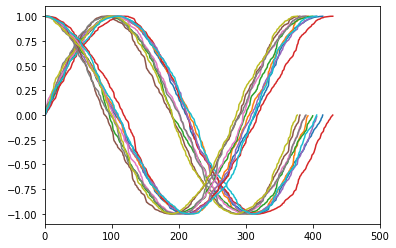

In [ ]:
n_samples = 10
length = 500
_a = []
for i in range(n_samples):
    a = np.arange(-4000, 4000, 10)
    mask = np.random.rand(len(a)) > .5
    a = a[mask]
    a = np.concatenate([a, np.array([np.nan] * (length - len(a)))])
    _a.append(a.reshape(-1,1))
a = np.concatenate(_a, -1).transpose(1,0)
sin, cos = encode_positions(a, linear=False)
test_eq(a.shape, (n_samples, length))
test_eq(sin.shape, (n_samples, length))
test_eq(cos.shape, (n_samples, length))
plt.plot(sin.T)
plt.plot(cos.T)
plt.xlim(0, 500)
plt.show()

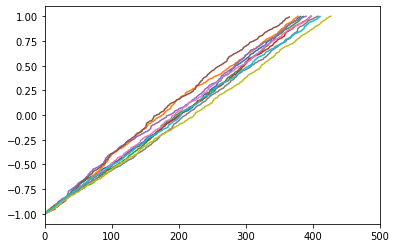

In [ ]:
n_samples = 10
length = 500
_a = []
for i in range(n_samples):
    a = np.arange(-4000, 4000, 10)
    mask = np.random.rand(len(a)) > .5
    a = a[mask]
    a = np.concatenate([a, np.array([np.nan] * (length - len(a)))])
    _a.append(a.reshape(-1,1))
a = np.concatenate(_a, -1).transpose(1,0)
lin = encode_positions(a, linear=True)
test_eq(a.shape, (n_samples, length))
test_eq(lin.shape, (n_samples, length))
plt.plot(lin.T)
plt.xlim(0, 500)
plt.show()

In [ ]:
#export
def sort_generator(generator, bs):
    g = list(generator)
    for i in range(len(g)//bs + 1): g[bs*i:bs*(i+1)] = np.sort(g[bs*i:bs*(i+1)])
    return (i for i in g)

In [ ]:
generator = (i for i in np.random.permutation(np.arange(1000000)).tolist())
l = list(sort_generator(generator, 512))
test_eq(l[:512], sorted(l[:512]))

In [ ]:
#export
def get_subset_dict(d, keys):
    return dict((k,d[k]) for k in listify(keys) if k in d)

In [ ]:
keys = string.ascii_lowercase
values = np.arange(len(keys))
d = {k:v for k,v in zip(keys,values)}
test_eq(get_subset_dict(d, ['a', 'k', 'j', 'e']), {'a': 0, 'k': 10, 'j': 9, 'e': 4})

In [ ]:
#export
def create_dir(directory, verbose=True): 
    if not is_listy(directory): directory = [directory]
    for d in directory:
        d = Path(d)
        if d.exists():
            if verbose: print(f"{d} directory already exists.")
        else: 
            d.mkdir(parents=True, exist_ok=True)
            assert d.exists(),  f"a problem has occurred while creating {d}"
            if verbose: print(f"{d} directory created.")


def remove_dir(directory, verbose=True):
    if not is_listy(directory): directory = [directory]
    for d in directory:
        d = Path(d)
        if d.is_file(): d = d.parent
        if not d.exists():
            if verbose: print(f"{d} directory doesn't exist.")
        else:
            shutil.rmtree(d)
            assert not d.exists(), f"a problem has occurred while deleting {d}"
            if verbose: print(f"{d} directory removed.")

In [ ]:
path = "wandb3/wandb2/wandb"
create_dir(path)
assert Path(path).exists()

paths = ["wandb3/wandb2/wandb", "wandb3/wandb2", "wandb"]
remove_dir(paths)
for p in paths: 
    assert not Path(p).exists()

path = "wandb3"
assert Path(path).exists()
remove_dir(path)
assert not Path(path).exists()

wandb3/wandb2/wandb directory created.
wandb3/wandb2/wandb directory removed.
wandb3/wandb2 directory removed.
wandb directory doesn't exist.
wandb3 directory removed.


In [ ]:
create_dir('./test')

test directory created.


In [ ]:
%%file ./test/mod_dev.py
a = 5
def fn(b): return a + b

Writing ./test/mod_dev.py


In [ ]:
fname = "./test/mod_dev.py"
while True: 
    if fname[0] in "/ .": fname = fname.split(fname[0], 1)[1]
    else: break
if '/' in fname and fname.rsplit('/', 1)[0] not in sys.path: sys.path.append(fname.rsplit('/', 1)[0])
mod = import_file_as_module(fname)
test_eq(mod.fn(3), 8)
sys.path = sys.path[:-1]
remove_dir('./test/')

test directory removed.


In [ ]:
#export
class named_partial(object):
    """Create a partial function with a __name__"""
    
    def __init__(self, name, func, *args, **kwargs):
        self._func = partial(func, *args, **kwargs)
        self.__name__ = name
    def __call__(self, *args, **kwargs):
        return self._func(*args, **kwargs)
    def __repr__(self):
        return self.__name__

In [ ]:
def add_1(x, add=1): return x+add
test_eq(add_1(1), 2)
add_2 = partial(add_1, add=2)
test_eq(add_2(2), 4)
test_ne(str(add_2), "add_2")
add_2 = named_partial('add_2', add_1, add=2)
test_eq(add_2(2), 4)
test_eq(str(add_2), "add_2")

class _A():
    def __init__(self, add=1): self.add = add
    def __call__(self, x): return x + self.add
    
test_eq(_A()(1), 2)
_A2 = partial(_A, add=2)
test_eq(_A2()(1), 3)
test_ne(str(_A2), '_A2')
_A2 = named_partial('_A2', _A, add=2)
test_eq(_A2()(1), 3)
test_eq(str(_A2), '_A2')

In [ ]:
# export
def yaml2dict(fname):
    with maybe_open(fname, 'r') as f:
        dictionary = yaml.safe_load(f)
    return dictionary

In [ ]:
%%file sweep_config.yaml

program: wandb_scripts/train_script.py          # (required) Path to training script.
method: bayes                                   # (required) Specify the search strategy: grid, random or bayes
parameters:                                     # (required) Specify parameters bounds to search.
   bs:
      values: [32, 64, 128]
   depth:
      values: [3, 6, 9, 12]
   fc_dropout:
      distribution: uniform
      min: 0.
      max: 0.5
   lr_max:
      values: [0.001, 0.003, 0.01, 0.03, 0.1]
   n_epoch:
      values: [10, 15, 20]
   nb_filters:
      values: [32, 64, 128]
name: LSST_sweep_01
metric: 
   name: accuracy                              # This must match one of the metrics in the training script
   goal: maximize
early_terminate: 
   type: hyperband
   min_iter: 3
project: LSST_wandb_hpo

Writing sweep_config.yaml


In [ ]:
fname = "sweep_config.yaml"
sweep_config = yaml2dict(fname)
test_eq(sweep_config['method'], 'bayes')
test_eq(sweep_config['metric'], {'name': 'accuracy', 'goal': 'maximize'})
os.remove(fname)

In [ ]:
#hide
out = create_scripts(); beep(out)

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 002b_data.unwindowed.ipynb.
Converted 002c_data.metadatasets.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_export.ipynb.
Converted 050_losses.ipynb.
Converted 051_metrics.ipynb.
Converted 052_learner.ipynb.
Converted 052b_tslearner.ipynb.
Converted 053_optimizer.ipynb.
Converted 060_callback.core.ipynb.
Converted 061_callback.noisy_student.ipynb.
Converted 063_callback.MVP.ipynb.
Converted 064_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Conve